# 🔍 Deepchecks Model Evaluation
# Premier League Points Prediction Model

This notebook provides comprehensive model evaluation using Deepchecks, including:
- Data integrity checks
- Model performance evaluation
- Distribution drift detection
- Feature importance analysis
- Predictions reliability

**Version Information:**
- Compatible with Deepchecks 0.19.1
- Uses suite-based evaluation (recommended approach)
- Some individual checks may vary by version

---

## 📦 Setup & Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Deepchecks - Core imports
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import (
    model_evaluation,
    train_test_validation,
    data_integrity
)

# Deepchecks - Individual checks (compatible with v0.19.1)
from deepchecks.tabular.checks import (
    ModelInfo,
    TrainTestPerformance,
    WeakSegmentsPerformance,
    TrainTestPredictionDrift,
    TrainTestFeatureDrift,
    DatasetsSizeComparison,
    NewLabelTrainTest,
    CategoryMismatchTrainTest,
    StringMismatchComparison,
    DateTrainTestLeakageDuplicates,
    IndexTrainTestLeakage,
    IsSingleValue,
    SpecialCharacters,
    MixedNulls,
    MixedDataTypes,
    StringMismatch,
    DataDuplicates,
    ConflictingLabels,
    OutlierSampleDetection,
    FeatureFeatureCorrelation,
    FeatureLabelCorrelation
)

# Try to import ModelErrorAnalysis - it may not be available in all versions
try:
    from deepchecks.tabular.checks.model_evaluation import ModelErrorAnalysis
    MODEL_ERROR_ANALYSIS_AVAILABLE = True
except (ImportError, ModuleNotFoundError):
    try:
        from deepchecks.tabular.checks import ModelErrorAnalysis
        MODEL_ERROR_ANALYSIS_AVAILABLE = True
    except (ImportError, ModuleNotFoundError):
        MODEL_ERROR_ANALYSIS_AVAILABLE = False
        print("⚠️  ModelErrorAnalysis not available in this Deepchecks version")

print("✅ All packages imported successfully!")
print(f"📦 Deepchecks version: {__import__('deepchecks').__version__}")

⚠️  ModelErrorAnalysis not available in this Deepchecks version
✅ All packages imported successfully!
📦 Deepchecks version: 0.19.1


## 🔧 Configuration

In [2]:
# Project paths
PROJECT_ROOT = Path().absolute().parent.parent
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models' / 'production'
REPORTS_DIR = PROJECT_ROOT / 'reports' / 'deepchecks'

# Create reports directory
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/7a99ui/premier_league_mlops.mlflow"
MODEL_NAME = "PremierLeagueModel"
MODEL_STAGE = "Production"  # or "Staging"

# Display configuration
print(f"📂 Project Root: {PROJECT_ROOT}")
print(f"📂 Data Directory: {DATA_DIR}")
print(f"📂 Models Directory: {MODELS_DIR}")
print(f"📂 Reports Directory: {REPORTS_DIR}")
print(f"\n🔗 MLflow Tracking URI: {MLFLOW_TRACKING_URI}")
print(f"📦 Model: {MODEL_NAME} ({MODEL_STAGE})")

📂 Project Root: c:\Users\akram\OneDrive\Bureau\premier_league_mlops
📂 Data Directory: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\data\processed
📂 Models Directory: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\models\production
📂 Reports Directory: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks

🔗 MLflow Tracking URI: https://dagshub.com/7a99ui/premier_league_mlops.mlflow
📦 Model: PremierLeagueModel (Production)


## 📊 Load Data

In [3]:
print("📥 Loading datasets...\n")

# Load train, validation, and test sets
train_df = pd.read_parquet(DATA_DIR / 'train.parquet')
val_df = pd.read_parquet(DATA_DIR / 'val.parquet')
test_df = pd.read_parquet(DATA_DIR / 'test.parquet')

print(f"✓ Train set: {len(train_df):,} samples")
print(f"✓ Validation set: {len(val_df):,} samples")
print(f"✓ Test set: {len(test_df):,} samples")

# Display dataset info
print(f"\n📊 Dataset shape: {train_df.shape}")
print(f"\n📅 Seasons in data:")
for season in sorted(train_df['season'].unique()):
    count = len(train_df[train_df['season'] == season])
    print(f"   - {season}: {count} samples")

📥 Loading datasets...

✓ Train set: 4,060 samples
✓ Validation set: 580 samples
✓ Test set: 580 samples

📊 Dataset shape: (4060, 53)

📅 Seasons in data:
   - 2015-2016: 580 samples
   - 2016-2017: 580 samples
   - 2017-2018: 580 samples
   - 2018-2019: 580 samples
   - 2019-2020: 580 samples
   - 2020-2021: 580 samples
   - 2021-2022: 580 samples


In [4]:
# Define feature and target columns
metadata_cols = ['season', 'team', 'gameweek']
target_col = 'target_final_points'

feature_cols = [
    col for col in train_df.columns 
    if col not in metadata_cols + [target_col, 'target_final_position']
]

print(f"📋 Number of features: {len(feature_cols)}")
print(f"📋 Target variable: {target_col}")

# Separate features and targets
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"\n✅ Data prepared for evaluation")
print(f"   Features shape: {X_train.shape}")
print(f"   Target shape: {y_train.shape}")

📋 Number of features: 49
📋 Target variable: target_final_points

✅ Data prepared for evaluation
   Features shape: (4060, 49)
   Target shape: (4060,)


## 🤖 Load Model from MLflow Registry

In [5]:
print(f"🔍 Loading model from MLflow Registry...\n")

# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

try:
    # Load model from registry
    model_uri = f"models:/{MODEL_NAME}/{MODEL_STAGE}"
    model = mlflow.sklearn.load_model(model_uri)
    
    print(f"✅ Model loaded successfully!")
    print(f"   Model URI: {model_uri}")
    
    # Get model metadata
    client = MlflowClient()
    model_versions = client.get_latest_versions(MODEL_NAME, stages=[MODEL_STAGE])
    
    if model_versions:
        model_version = model_versions[0]
        print(f"\n📦 Model Information:")
        print(f"   Version: {model_version.version}")
        print(f"   Stage: {model_version.current_stage}")
        print(f"   Status: {model_version.status}")
        
        # Get run metrics
        run = client.get_run(model_version.run_id)
        metrics = run.data.metrics
        
        print(f"\n📊 Training Metrics:")
        if 'val_mae' in metrics:
            print(f"   Val MAE: {metrics['val_mae']:.2f} points")
        if 'val_rmse' in metrics:
            print(f"   Val RMSE: {metrics['val_rmse']:.2f} points")
        if 'val_r2' in metrics:
            print(f"   Val R²: {metrics['val_r2']:.4f}")
        if 'test_mae' in metrics:
            print(f"   Test MAE: {metrics['test_mae']:.2f} points")
        if 'test_r2' in metrics:
            print(f"   Test R²: {metrics['test_r2']:.4f}")

except Exception as e:
    print(f"⚠️  Could not load model from MLflow Registry: {e}")
    print(f"\n🔄 Trying to load local model...")
    
    # Fallback to local model
    local_model_path = MODELS_DIR / 'latest_model.joblib'
    
    if local_model_path.exists():
        model = joblib.load(local_model_path)
        print(f"✅ Local model loaded successfully!")
        print(f"   Path: {local_model_path}")
        
        # Load metadata if available
        metadata_path = MODELS_DIR / 'latest_metadata.json'
        if metadata_path.exists():
            import json
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            
            print(f"\n📊 Model Metrics:")
            if 'metrics' in metadata:
                for key, value in metadata['metrics'].items():
                    print(f"   {key}: {value:.2f}")
    else:
        raise FileNotFoundError(f"No model found at {local_model_path}")

🔍 Loading model from MLflow Registry...



✅ Model loaded successfully!
   Model URI: models:/PremierLeagueModel/Production

📦 Model Information:
   Version: 2
   Stage: Production
   Status: READY

📊 Training Metrics:
   Val MAE: 5.03 points
   Val RMSE: 6.62 points
   Val R²: 0.8606
   Test MAE: 4.98 points
   Test R²: 0.8937


## 🎯 Generate Predictions

In [6]:
print("🎯 Generating predictions...\n")

# Generate predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

print(f"✅ Predictions generated for all datasets")

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📊 {dataset_name} Metrics:")
    print(f"   MAE:  {mae:.2f} points")
    print(f"   RMSE: {rmse:.2f} points")
    print(f"   R²:   {r2:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

train_metrics = calculate_metrics(y_train, y_train_pred, "Train")
val_metrics = calculate_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

🎯 Generating predictions...

✅ Predictions generated for all datasets

📊 Train Metrics:
   MAE:  4.16 points
   RMSE: 5.56 points
   R²:   0.9059

📊 Validation Metrics:
   MAE:  5.03 points
   RMSE: 6.62 points
   R²:   0.8606

📊 Test Metrics:
   MAE:  4.98 points
   RMSE: 6.43 points
   R²:   0.8937


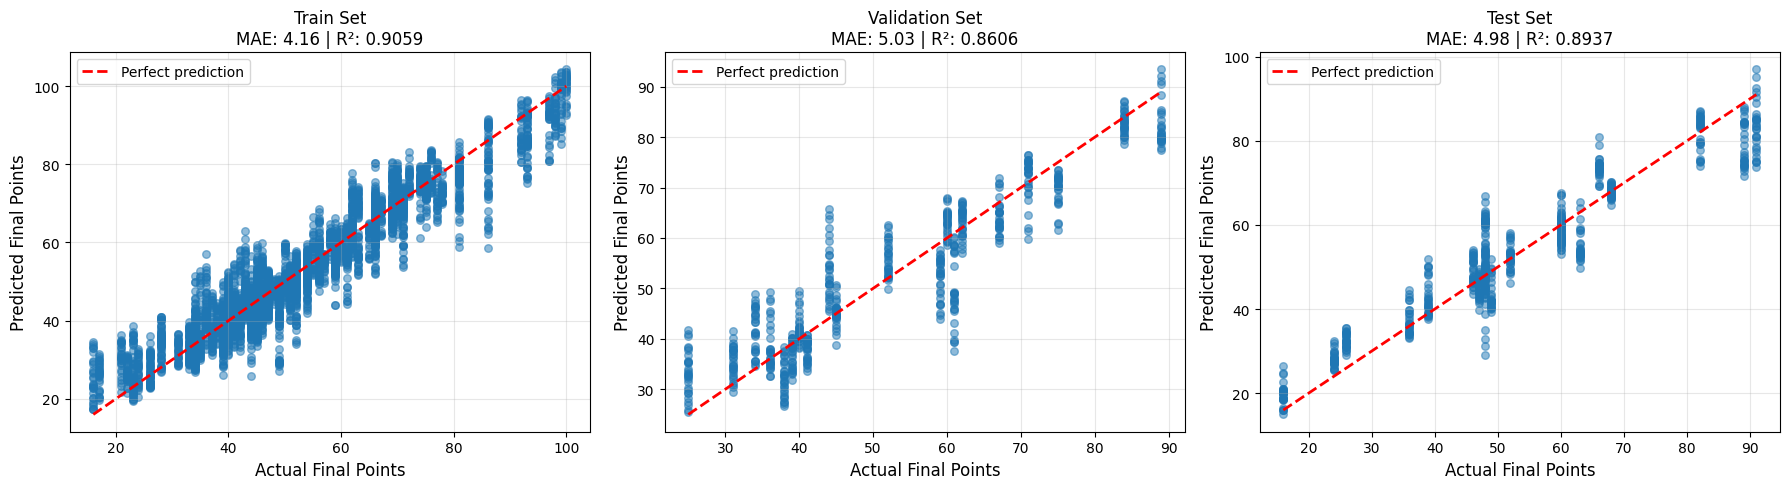


💾 Plot saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\predictions_vs_actual.png


In [7]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (y_train, y_train_pred, "Train", train_metrics),
    (y_val, y_val_pred, "Validation", val_metrics),
    (y_test, y_test_pred, "Test", test_metrics)
]

for ax, (y_true, y_pred, name, metrics) in zip(axes, datasets):
    ax.scatter(y_true, y_pred, alpha=0.5, s=30)
    ax.plot([y_true.min(), y_true.max()], 
            [y_true.min(), y_true.max()], 
            'r--', lw=2, label='Perfect prediction')
    
    ax.set_xlabel('Actual Final Points', fontsize=12)
    ax.set_ylabel('Predicted Final Points', fontsize=12)
    ax.set_title(f'{name} Set\nMAE: {metrics["mae"]:.2f} | R²: {metrics["r2"]:.4f}', 
                 fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Plot saved to: {REPORTS_DIR / 'predictions_vs_actual.png'}")

## 🔍 Create Deepchecks Datasets

In [8]:
print("🔍 Creating Deepchecks datasets...\n")

# Create Deepchecks Dataset objects
train_dataset = Dataset(
    df=train_df[feature_cols + [target_col]],
    label=target_col,
    cat_features=[],  # No categorical features after encoding
    features=feature_cols
)

val_dataset = Dataset(
    df=val_df[feature_cols + [target_col]],
    label=target_col,
    cat_features=[],
    features=feature_cols
)

test_dataset = Dataset(
    df=test_df[feature_cols + [target_col]],
    label=target_col,
    cat_features=[],
    features=feature_cols
)

print(f"✅ Deepchecks datasets created successfully!")
print(f"   Train dataset: {len(train_dataset)} samples")
print(f"   Validation dataset: {len(val_dataset)} samples")
print(f"   Test dataset: {len(test_dataset)} samples")

🔍 Creating Deepchecks datasets...

✅ Deepchecks datasets created successfully!
   Train dataset: 4060 samples
   Validation dataset: 580 samples
   Test dataset: 580 samples


---
# 🧪 DEEPCHECKS EVALUATION SUITES
---

## 1️⃣ Data Integrity Suite

Validates the quality and consistency of training data:
- Missing values
- Duplicates
- Data types
- Outliers
- Feature correlations

In [9]:
print("\n" + "="*70)
print("1️⃣  DATA INTEGRITY SUITE")
print("="*70 + "\n")

# Run data integrity suite
integrity_suite = data_integrity()
integrity_result = integrity_suite.run(train_dataset)

# Display results
integrity_result.show()

# Save report
integrity_result.save_as_html(str(REPORTS_DIR / 'data_integrity_report.html'))
print(f"\n💾 Report saved to: {REPORTS_DIR / 'data_integrity_report.html'}")


1️⃣  DATA INTEGRITY SUITE



Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_SSVDUY4LMSE4R34A4MH25494G">Data Integrity Sui…


💾 Report saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\data_integrity_report.html


## 2️⃣ Train-Test Validation Suite

Compares training and test datasets:
- Distribution drift
- Label drift
- Feature drift
- Data leakage

In [10]:
print("\n" + "="*70)
print("2️⃣  TRAIN-TEST VALIDATION SUITE")
print("="*70 + "\n")

# Run train-test validation suite
validation_suite = train_test_validation()
validation_result = validation_suite.run(
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

# Display results
validation_result.show()

# Save report
validation_result.save_as_html(str(REPORTS_DIR / 'train_test_validation_report.html'))
print(f"\n💾 Report saved to: {REPORTS_DIR / 'train_test_validation_report.html'}")


2️⃣  TRAIN-TEST VALIDATION SUITE



Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_8RDEEE3MZTXZTBCEM8CVBIT8D">Train Test Validat…


💾 Report saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\train_test_validation_report.html


## 3️⃣ Model Evaluation Suite

Comprehensive model performance evaluation:
- Performance metrics
- Feature importance (included in suite)
- Error analysis
- Weak segments detection

**Note:** Feature Importance is automatically included in this suite and doesn't need to be run separately.

In [11]:
print("\n" + "="*70)
print("3️⃣  MODEL EVALUATION SUITE")
print("="*70 + "\n")

# Run model evaluation suite
evaluation_suite = model_evaluation()
evaluation_result = evaluation_suite.run(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=model
)

# Display results
evaluation_result.show()

# Save report
evaluation_result.save_as_html(str(REPORTS_DIR / 'model_evaluation_report.html'))
print(f"\n💾 Report saved to: {REPORTS_DIR / 'model_evaluation_report.html'}")


3️⃣  MODEL EVALUATION SUITE



Model Evaluation Suite: 
 
 
 
 0/11 [Time: 00:00]

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_Z6I4D163A76D8OXFX7SAQS4MF">Model Evaluation S…


💾 Report saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\model_evaluation_report.html


---
# 🎯 INDIVIDUAL CHECKS
---

## 📊 Train-Test Performance Comparison

In [15]:
print("\n📊 Train-Test Performance Comparison\n")

check = TrainTestPerformance()
result = check.run(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=model
)
result.show()


📊 Train-Test Performance Comparison



## 🎯 Feature Importance Extraction

**Note:** Since `FeatureImportance` check is not available as a standalone in Deepchecks 0.19.1,
we extract it directly from the model or from the Model Evaluation Suite results.


🎯 Feature Importance Analysis

Top 20 Most Important Features (by absolute coefficient):
                    feature  importance
0          current_position    3.548181
1            current_points    2.848391
4                    losses    2.219473
6   goals_conceded_per_game    1.827958
33           vs_bottom6_ppg    1.769015
35    avg_total_scoring_att    1.724434
31              vs_top6_ppg    1.313447
28  longest_unbeaten_streak    1.195630
23        high_scoring_rate    1.150103
36    std_total_scoring_att    1.144060
20          failed_to_score    0.892751
32               vs_mid_ppg    0.734918
38           avg_total_pass    0.624901
46            shot_accuracy    0.589753
41         std_total_tackle    0.548722
27       longest_win_streak    0.537906
3                     draws    0.518939
44                avg_saves    0.443705
21         clean_sheet_rate    0.424833
45                std_saves    0.315961


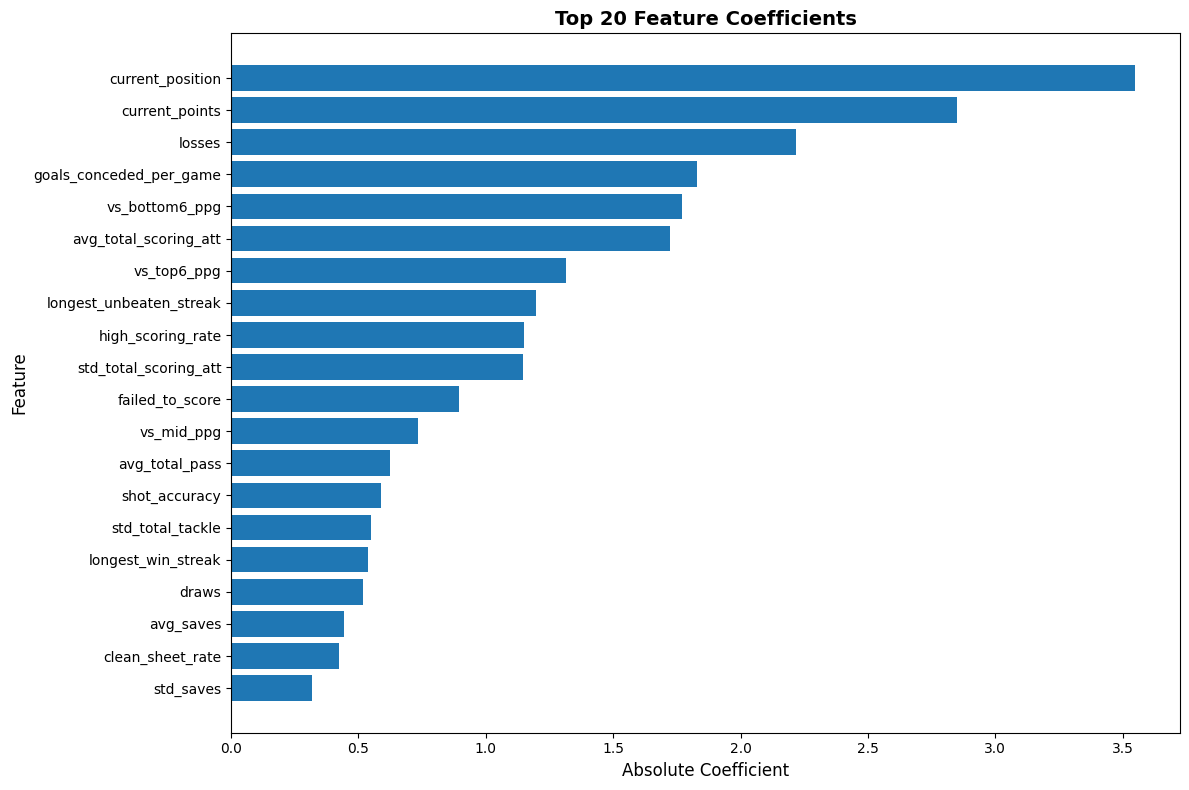


💾 Plot saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\feature_importance.png


In [13]:
print("\n🎯 Feature Importance Analysis\n")

# Try to get feature importance from the model
try:
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("Top 20 Most Important Features:")
        print(feature_importance_df.head(20))
        
        # Visualize
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(REPORTS_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n💾 Plot saved to: {REPORTS_DIR / 'feature_importance.png'}")
        
    elif hasattr(model, 'coef_'):
        # For linear models
        coefficients = np.abs(model.coef_)
        feature_importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': coefficients
        }).sort_values('importance', ascending=False)
        
        print("Top 20 Most Important Features (by absolute coefficient):")
        print(feature_importance_df.head(20))
        
        # Visualize
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Absolute Coefficient', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Top 20 Feature Coefficients', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(REPORTS_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n💾 Plot saved to: {REPORTS_DIR / 'feature_importance.png'}")
        
    elif hasattr(model, 'estimators_'):
        # For ensemble models (stacking, voting)
        print("⚠️  Ensemble model detected. Feature importance depends on base estimators.")
        print("   Check the Model Evaluation Suite results for detailed importance analysis.")
        
    else:
        print("⚠️  Model does not have feature_importances_ or coef_ attributes.")
        print("   Feature importance is available in the Model Evaluation Suite results.")
        
except Exception as e:
    print(f"⚠️  Could not extract feature importance: {e}")
    print("   Feature importance is available in the Model Evaluation Suite results.")

## 🔍 Model Error Analysis

In [17]:
print("\n🔍 Model Error Analysis\n")

if MODEL_ERROR_ANALYSIS_AVAILABLE:
    try:
        check = ModelErrorAnalysis()
        result = check.run(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            model=model
        )
        result.show()
    except Exception as e:
        print(f"⚠️  ModelErrorAnalysis failed: {e}")
        print("   See the Model Evaluation Suite results for error analysis.")
else:
    print("⚠️  ModelErrorAnalysis check is not available in this Deepchecks version.")
    print("   This functionality is included in the Model Evaluation Suite results above.")


🔍 Model Error Analysis

⚠️  ModelErrorAnalysis check is not available in this Deepchecks version.
   This functionality is included in the Model Evaluation Suite results above.


## 📈 Prediction Drift Detection

In [21]:
print("\n📈 Prediction Drift Detection\n")

check = TrainTestPredictionDrift()
result = check.run(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=model
)
result.show()


📈 Prediction Drift Detection



## 🌊 Feature Drift Detection

In [22]:
print("\n🌊 Feature Drift Detection\n")

check = TrainTestFeatureDrift()
result = check.run(
    train_dataset=train_dataset,
    test_dataset=test_dataset
)
result.show()


🌊 Feature Drift Detection



## 🔗 Feature-Feature Correlation

In [23]:
print("\n🔗 Feature-Feature Correlation\n")

check = FeatureFeatureCorrelation()
result = check.run(dataset=train_dataset)
result.show()


🔗 Feature-Feature Correlation



## 🎯 Feature-Label Correlation

In [24]:
print("\n🎯 Feature-Label Correlation\n")

check = FeatureLabelCorrelation()
result = check.run(dataset=train_dataset)
result.show()


🎯 Feature-Label Correlation



---
# 📊 CUSTOM ANALYSIS
---

## 🎲 Prediction Distribution Analysis


🎲 Prediction Distribution Analysis



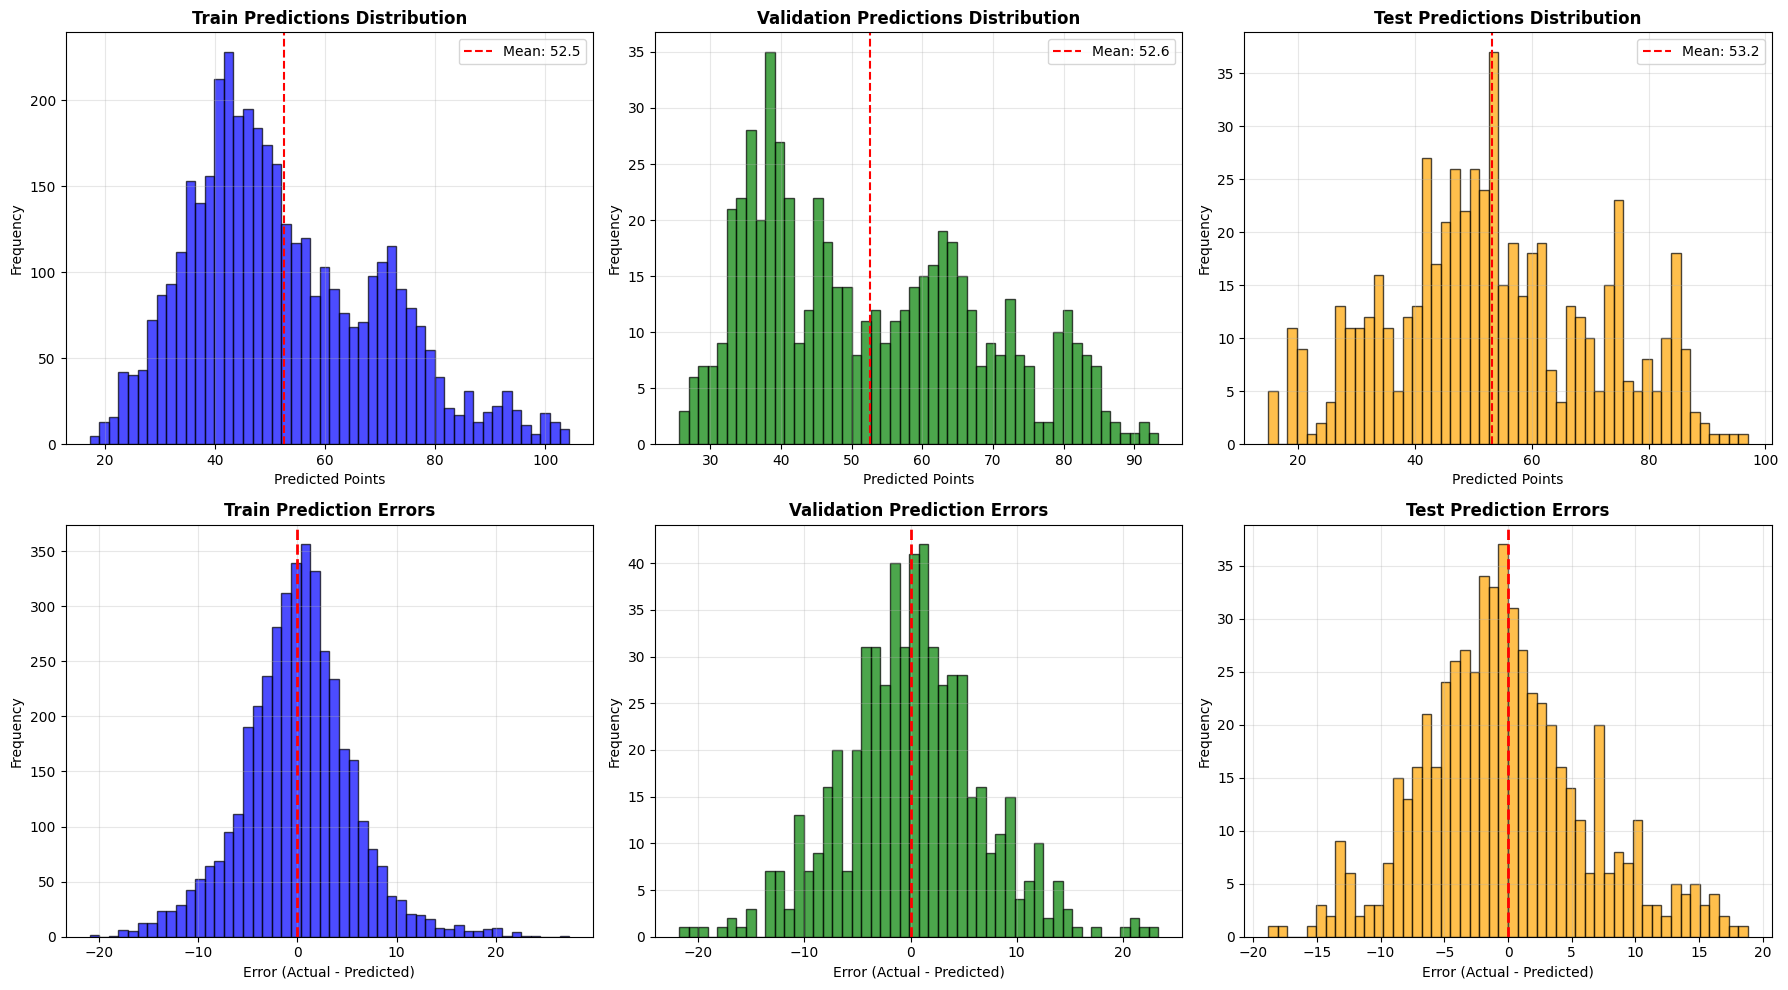


💾 Plot saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\prediction_distributions.png


In [25]:
print("\n🎲 Prediction Distribution Analysis\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Train predictions
axes[0, 0].hist(y_train_pred, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Train Predictions Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Points')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(y_train_pred.mean(), color='red', linestyle='--', 
                    label=f'Mean: {y_train_pred.mean():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Val predictions
axes[0, 1].hist(y_val_pred, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Validation Predictions Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Points')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(y_val_pred.mean(), color='red', linestyle='--', 
                    label=f'Mean: {y_val_pred.mean():.1f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Test predictions
axes[0, 2].hist(y_test_pred, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 2].set_title('Test Predictions Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Predicted Points')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(y_test_pred.mean(), color='red', linestyle='--', 
                    label=f'Mean: {y_test_pred.mean():.1f}')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Train errors
train_errors = y_train - y_train_pred
axes[1, 0].hist(train_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_title('Train Prediction Errors', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Error (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].grid(True, alpha=0.3)

# Val errors
val_errors = y_val - y_val_pred
axes[1, 1].hist(val_errors, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].set_title('Validation Prediction Errors', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Error (Actual - Predicted)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)

# Test errors
test_errors = y_test - y_test_pred
axes[1, 2].hist(test_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 2].set_title('Test Prediction Errors', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Error (Actual - Predicted)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'prediction_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Plot saved to: {REPORTS_DIR / 'prediction_distributions.png'}")

## 📉 Residual Analysis


📉 Residual Analysis



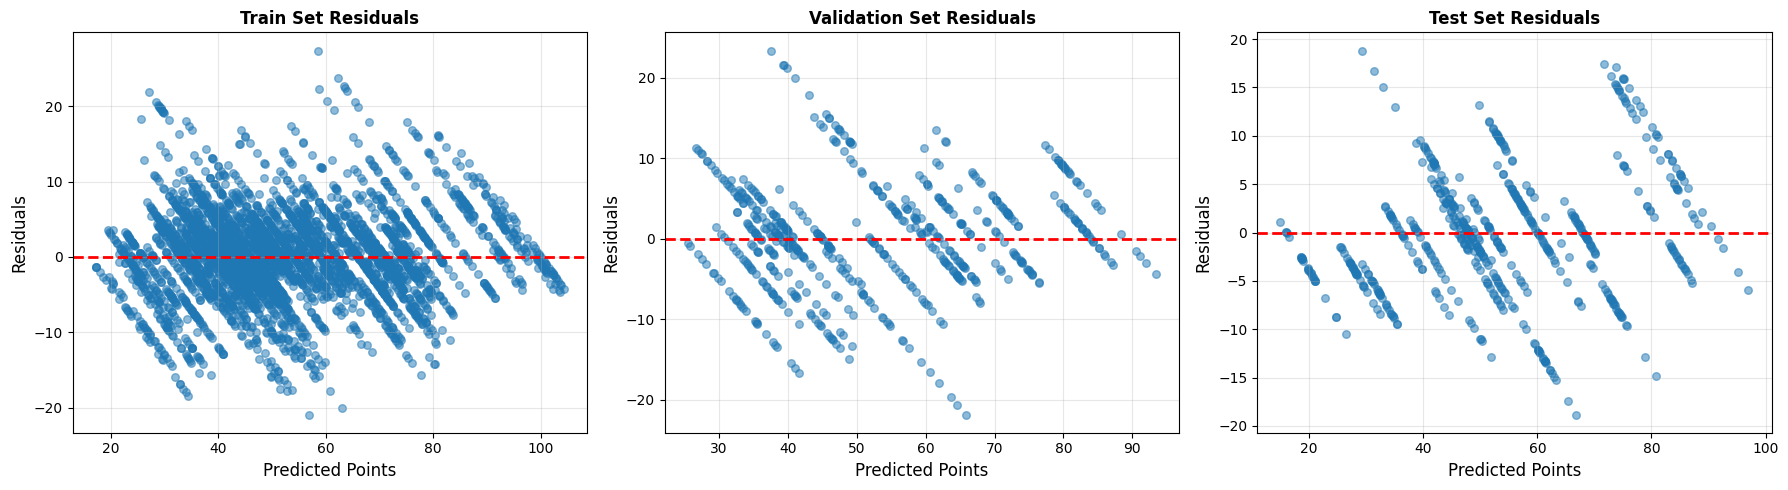


💾 Plot saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\residual_plots.png


In [26]:
print("\n📉 Residual Analysis\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (y_train, y_train_pred, "Train"),
    (y_val, y_val_pred, "Validation"),
    (y_test, y_test_pred, "Test")
]

for ax, (y_true, y_pred, name) in zip(axes, datasets):
    residuals = y_true - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.5, s=30)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted Points', fontsize=12)
    ax.set_ylabel('Residuals', fontsize=12)
    ax.set_title(f'{name} Set Residuals', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Plot saved to: {REPORTS_DIR / 'residual_plots.png'}")

## 🎯 Error by Prediction Range


🎯 Error Analysis by Prediction Range

Error Statistics by Predicted Points Range:
         error            
          mean   std count
pred_bin                  
0-30      3.98  2.80    57
30-40     4.74  3.78    69
40-50     3.45  2.82   139
50-60     5.08  3.32   124
60-70     4.92  5.61    76
70-80     9.73  4.33    61
80+       4.70  3.02    54


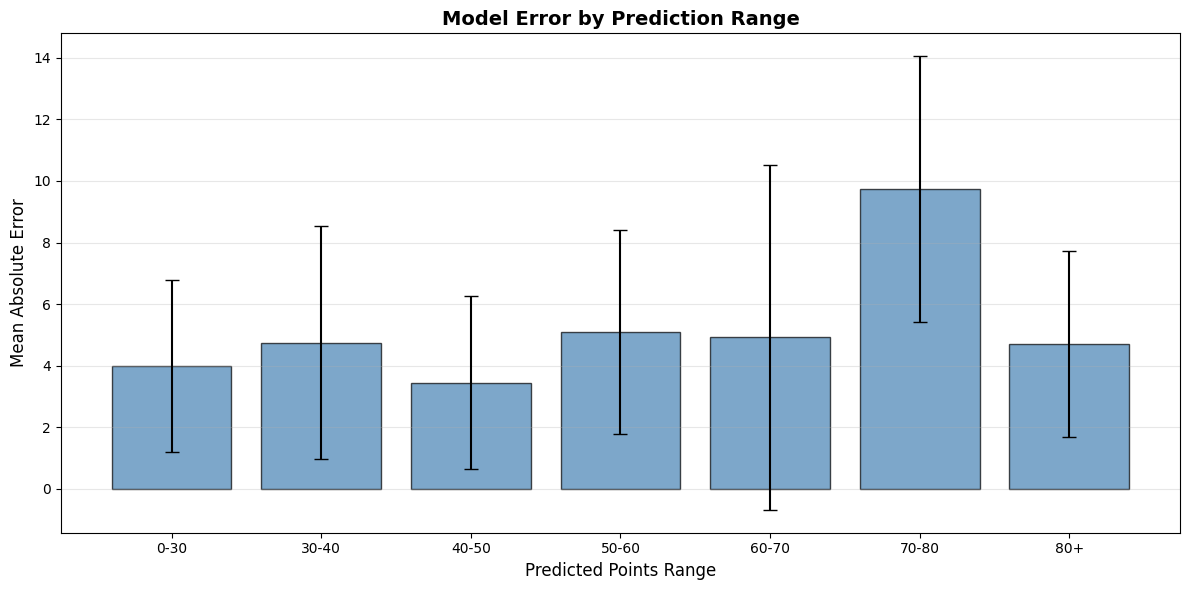


💾 Plot saved to: c:\Users\akram\OneDrive\Bureau\premier_league_mlops\reports\deepchecks\error_by_range.png


In [27]:
print("\n🎯 Error Analysis by Prediction Range\n")

# Create prediction bins
bins = [0, 30, 40, 50, 60, 70, 80, 100]
bin_labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

# Analyze test set
test_df_analysis = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'error': np.abs(y_test - y_test_pred)
})

test_df_analysis['pred_bin'] = pd.cut(
    test_df_analysis['predicted'], 
    bins=bins, 
    labels=bin_labels
)

# Calculate statistics by bin
error_by_range = test_df_analysis.groupby('pred_bin').agg({
    'error': ['mean', 'std', 'count']
}).round(2)

print("Error Statistics by Predicted Points Range:")
print(error_by_range)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

error_stats = test_df_analysis.groupby('pred_bin')['error'].agg(['mean', 'std'])
x = range(len(error_stats))

ax.bar(x, error_stats['mean'], yerr=error_stats['std'], 
       capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(error_stats.index)
ax.set_xlabel('Predicted Points Range', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Model Error by Prediction Range', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'error_by_range.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Plot saved to: {REPORTS_DIR / 'error_by_range.png'}")

---
# 📝 SUMMARY REPORT
---

In [28]:
from datetime import datetime

print("\n" + "="*70)
print("📝 MODEL EVALUATION SUMMARY")
print("="*70)

summary = f"""
# Model Evaluation Report
**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Information
- **Model Name:** {MODEL_NAME}
- **Stage:** {MODEL_STAGE}
- **Model Type:** {type(model).__name__}

## Dataset Statistics
- **Train Samples:** {len(X_train):,}
- **Validation Samples:** {len(X_val):,}
- **Test Samples:** {len(X_test):,}
- **Number of Features:** {len(feature_cols)}

## Performance Metrics

### Train Set
- MAE: {train_metrics['mae']:.2f} points
- RMSE: {train_metrics['rmse']:.2f} points
- R²: {train_metrics['r2']:.4f}

### Validation Set
- MAE: {val_metrics['mae']:.2f} points
- RMSE: {val_metrics['rmse']:.2f} points
- R²: {val_metrics['r2']:.4f}

### Test Set
- MAE: {test_metrics['mae']:.2f} points
- RMSE: {test_metrics['rmse']:.2f} points
- R²: {test_metrics['r2']:.4f}

## Overfitting Analysis
- Train-Test MAE Difference: {abs(train_metrics['mae'] - test_metrics['mae']):.2f} points
- Train-Test R² Difference: {abs(train_metrics['r2'] - test_metrics['r2']):.4f}

## Deepchecks Reports
1. Data Integrity Report: `data_integrity_report.html`
2. Train-Test Validation: `train_test_validation_report.html`
3. Model Evaluation: `model_evaluation_report.html`

## Visualizations
1. Predictions vs Actual: `predictions_vs_actual.png`
2. Prediction Distributions: `prediction_distributions.png`
3. Residual Plots: `residual_plots.png`
4. Error by Range: `error_by_range.png`

---
*All reports and visualizations are saved in: `{REPORTS_DIR}`*
"""

# Save summary
summary_path = REPORTS_DIR / 'evaluation_summary.md'
with open(summary_path, 'w') as f:
    f.write(summary)

print(summary)
print(f"\n💾 Summary saved to: {summary_path}")
print(f"\n✅ Model evaluation complete!")
print(f"\n📂 All reports saved to: {REPORTS_DIR}")


📝 MODEL EVALUATION SUMMARY

# Model Evaluation Report
**Generated:** 2025-12-17 20:04:29

## Model Information
- **Model Name:** PremierLeagueModel
- **Stage:** Production
- **Model Type:** Lasso

## Dataset Statistics
- **Train Samples:** 4,060
- **Validation Samples:** 580
- **Test Samples:** 580
- **Number of Features:** 49

## Performance Metrics

### Train Set
- MAE: 4.16 points
- RMSE: 5.56 points
- R²: 0.9059

### Validation Set
- MAE: 5.03 points
- RMSE: 6.62 points
- R²: 0.8606

### Test Set
- MAE: 4.98 points
- RMSE: 6.43 points
- R²: 0.8937

## Overfitting Analysis
- Train-Test MAE Difference: 0.82 points
- Train-Test R² Difference: 0.0122

## Deepchecks Reports
1. Data Integrity Report: `data_integrity_report.html`
2. Train-Test Validation: `train_test_validation_report.html`
3. Model Evaluation: `model_evaluation_report.html`

## Visualizations
1. Predictions vs Actual: `predictions_vs_actual.png`
2. Prediction Distributions: `prediction_distributions.png`
3. Residual Plo

---
# 🎓 Next Steps

Based on the Deepchecks evaluation results:

1. **Review Data Integrity Issues:**
   - Check for missing values and duplicates
   - Investigate outliers
   - Validate data types

2. **Address Distribution Drift:**
   - If drift detected, consider retraining
   - Update feature engineering pipeline
   - Monitor drift over time

3. **Improve Model Performance:**
   - Focus on weak segments
   - Analyze high-error predictions
   - Consider ensemble methods

4. **Production Readiness:**
   - Set up monitoring pipeline
   - Define alert thresholds
   - Implement automated retraining

---